# JSL49_02 (CF-900)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [5]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import scipy.signal
import scipy.fftpack
import json, codecs, scipy, scipy.constants
from IPython.core.display import display, HTML
import mjsplot as mplt
import dateutil
# Plotting 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
hbar = scipy.constants.hbar
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename,folder='data'): # a way to load in many different files and keep track of them.
    if 'jsonl' in filename:
        datafile = list(map(lambda x: json.loads(x) if len(x)>0 else {},codecs.open('../'+folder+'/'+filename).read().split('\n')))
        key = filename[-15:-11]
        df[key] = pd.DataFrame(datafile)
    else:
        datafile = json.loads( codecs.open('../'+folder+'/'+filename,'r','utf-8').read() )
        key = datafile['attr']['_file counter']
        d[key]= datafile
        df[key] = pd.DataFrame(datafile['data'])

# Find best match
def find_nu(Bsdh):
    nu = np.linspace(20,1,20)
    Bnu = Phi_0/nu
    Bnu_diff = [t/s for s, t in zip(Bnu, Bnu[1:])]
    Bsdh_diff = np.array([t/s for s, t in zip(Bsdh, Bsdh[1:])])
    size_part = len(Bsdh_diff)
    residuals = [np.sum(Bnu_diff[i:i+size_part]-Bsdh_diff) for i in range(len(Bnu_diff)-size_part+1)]
    idx = np.argmin(np.abs(residuals))
    return nu[idx:idx+len(Bsdh)]

# Extract single subband density and density
def single_subband(Bsdh_all,r_df):
    n_band, mu_band, nu_band = [],[],[]
    for vgt,Bsdh in Bsdh_all.items():
        # Find best matching filling factors
        nu = find_nu(Bsdh)
        n = np.mean(Bsdh*nu/Phi_0)*1e-4 
        if isinstance(r_df, pd.DataFrame):
            mu = 1/(r_df[r_df['v'] == vgt]['rho'].values[0] * n * e)
        elif isinstance(r_df, float):
            mu = 1/(r_df * n * e)
        else:
            raise TypeError('r_df should be a pd.Dataframe or a float (when supplying rho_xx directly).')
        B_nu = n*1e4*Phi_0/nu
        nu_band.append(nu)
        n_band.append(n)
        mu_band.append(mu)
    return [nu_band,n_band,mu_band],[B_nu,nu]

# Plot single subband extracted from SdH
def plot_subband_gate(v_tot,n_tot,band1,colors=None,save=False,rows=1,cols=3):
    """
        TODO
    """
    [nu_band1, n_band1, mu_band1] = band1
    fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(7*cols,5*rows))
    axes = [ax[0]]*3+[ax[1]]+[ax[2]]
    plots = [([vgt for vgt,_ in Bsdh_all.items()], np.array(n_band1)*10),
             (v_tot, np.array(n_tot)-np.array(n_band1)),
             (v_tot, n_tot),
             ([vgt for vgt,_ in Bsdh_all.items()],mu_band1),
             (n_band1,mu_band1)]
    labels = ['Subband 1 (10x)','Other subband(s)','Total','','']
    linestyles = ['o-','o-','v-','o-','o-']
    if not colors:
        colors = ['green','blue','cyan','green','green']
    axes_labels = [('Vgate / V',u'Density / cm$^{2}$'),('Vgate / V',u'Density / cm$^{2}$'),
                   ('Vgate / V',u'Density / cm$^{2}$'),('Vgate / V',u'Mobility / cm$^{2}$/Vs'),
                   (u'Density / cm$^{2}$)',u'Mobility / cm$^{2}$/Vs')]
    titles = ['Densities of both subbands vs gate']*3+['Mobility of subband 1']+['Mobility subband 1 vs density']
        
    for axis,plot,label,ls,color,axis_labels,title in zip(axes,plots,labels,linestyles,colors,axes_labels,titles):
        axis.plot(*plot,ls,label=label)
        axis.set_xlabel(axis_labels[0])
        axis.set_ylabel(axis_labels[1])
        axis.set_title(title)
        axis.grid(which='major')
    fig.legend(loc='upper left', bbox_to_anchor=(0.05,0.9))
    fig.tight_layout()
    if save:
        fig.savefig('../plots/'+save)

def fft_SdH(cdf,x,y,start,end,N=501,xlim=200,ylim=10e-6,fit=True):
    Vxx = scipy.interpolate.interp1d(1/cdf[x],cdf[y],kind='linear')
    start, end = 1/end,1/start
    dB = (end-start)/(N-1)
    tdf = cdf[ ( 1/cdf[x] > start ) & ( 1/cdf[x] < end ) ]
    B = np.linspace(start,end,N) 
    yf = scipy.fftpack.fft(Vxx(B))
    xf = np.linspace(0.0, 1.0/(2.0*dB), N//2)
    pyf = 2.0/N * np.abs(yf[:N//2])
    
    # Plot
    fig, axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
    plots = [(B,Vxx(B)), (xf, pyf)]
    xlims = [(None,None),(0,xlim)]
    ylims = [(None,None),(0,ylim)]
    titles= ['Data','FFT spectrum']
    for ax,plot,xl,yl,title in zip(axes,plots,xlims,ylims,titles):
        ax.plot(*plot, '-',label='interp')
        ax.set_title(title)
        ax.set_xlim(*xl)
        ax.set_ylim(*yl)
    plt.show()
    
    if fit:
        xpeaks = [int(i) for i in input("X-position estimates of peaks (space separated)").split()]
        bounds = [[i-5,i+5] for i in xpeaks]    
        peaks = {}
        for bnd,i in zip(bounds,range(len(bounds))):
            idx = [np.abs(xf - a0).argmin() for a0 in bnd]
            peaks['Subband '+str(i+1)] = xf[idx[0]+np.argmax(pyf[idx[0]:idx[1]])]

        fig2, axes2 = plt.subplots(figsize=(8,5))    
        for key,peak in peaks.items():
            axes2.plot(xf, pyf, '-',label='interp')
            axes2.axvline(x=peak,color='gray',ls=':')
            axes2.set_xlim(0,xlim)
            axes2.set_ylim(0,ylim)
        plt.show()
        # Calculate densities from found peaks
        for subband,period in peaks.items():
            n = period/Phi_0
            print(subband+' density: {0:.2e}'.format(n*1e-4))
        print("Total density is {0:.2e} cm^-2".format(sum(peaks.values())/Phi_0*1e-4))
        
# QTplot compatibility
def _mlog(s,quite):
    if not quite:
        print(s)
def _saveBackwardsCompatableFiles(file_path,d,quite=True):
    _mlog('save backwards files for compatability',quite)
    #df = pd.DataFrame(d['data'])
    shortFilepath = file_path[:-5]
    the_time = dateutil.parser.parse(d['attr']['_time start'])
    _mlog('Making a .set file',quite)
    s ='Filename: '+ shortFilepath.split('\\')[-1] + '\n'
    s += 'Timestamp: ' + the_time.strftime("%a %b %d %H:%M:%S %Y") + '\n\n'
    for device in d['attr']['_devices start']:
        s+= 'Instrument: ' + str(device) + ' \n'
        for setting in d['attr']['_devices start'][device]:
            s += '\t' + str(setting) + ': ' + str(d['attr']['_devices start'][device][setting]) +'\n'

    with open(shortFilepath+'.set', 'w') as f:
        f.write(s)
     
    
    _mlog('Making a .dat file',quite)
    s  ='# Filename: '+ shortFilepath.split('\\')[-1]+'.dat' + '\n'
    s += '# Timestamp: ' +  the_time.strftime("%a %b %d %H:%M:%S %Y") + '\n\n'
    i=1; #keep track of column numbers
    keys = []
    #for k in d['attr']['_coordinates']:
    for k_idx in range(len(d['attr']['_coordinates'])):
        k = d['attr']['_coordinates'][k_idx]['name']
        keys.append(k)
        s += '# Column ' + str(i) +":\n"
        s+= '#\tend: '+str(d['attr']['_coordinates'][k_idx]['max']) + '\n'
        s+= '#\tname: '+ str(k) + '\n'
        s+= '#\tsize: '+ str(d['attr']['_coordinates'][k_idx]['size']) + '\n'
        s+= '#\tstart: '+ str(d['attr']['_coordinates'][k_idx]['min']) + '\n'
        s += '#\ttype: coordinate\n'
        i+=1
    cordnames = [ el['name'] for el in d['attr']['_coordinates'] ] 
    for col in d['data']:
        if col not in cordnames:
            keys.append(col)
            s += '# Column ' + str(i) +":\n"
            s += '#\tname: ' + str( col ) +"\n"
            s += '#\ttype: value\n'
            i += 1
    
    s+= '\n'
    #try to remove this line
    #s += df.to_csv(sep='\t' ,columns = keys, index=False, header=False)
    maxl = len(d['data'][keys[0]])
    l=0
    linetext = []
    while l < maxl:
        for j in range(len(keys)):
            linetext.append (  str( d['data'][keys[j]][l] ) )
        s += '\t'.join(linetext) + '\n'
        linetext = []
        l+=1
    
    with open(shortFilepath+'.dat', 'w') as f:
        f.write(s)
        
    _mlog('Making a .meta.txt file',quite)
    s = ''
    i=0
    if '_coordinates' in d['attr']:
        #for k in d['attr']['_coordinates']:
        for k_index in range(len(d['attr']['_coordinates'])):
            s+= str(d['attr']['_coordinates'][k_index]['size']) + '\n'
            s+= str(d['attr']['_coordinates'][k_index]['min']) + '\n'
            s+= str(d['attr']['_coordinates'][k_index]['max']) + '\n'
            s+= str(d['attr']['_coordinates'][k_index]['name']) + '\n'
            i+=1
        for col in d['data']:
            if col not in cordnames:
                # it is a value not a coordinates
                i+=1
                s+= str(i) + '\n'
                s+= str(col)+ '\n'
    with open(shortFilepath+'.meta.txt', 'w') as f:
        f.write(s)

# Hallbar 1

## Density and mobility

Single QH scan

Density and mobility from Rxy:
n = 2.83e+12 cm^-2
mu = 13056.67 cm^2/Vs


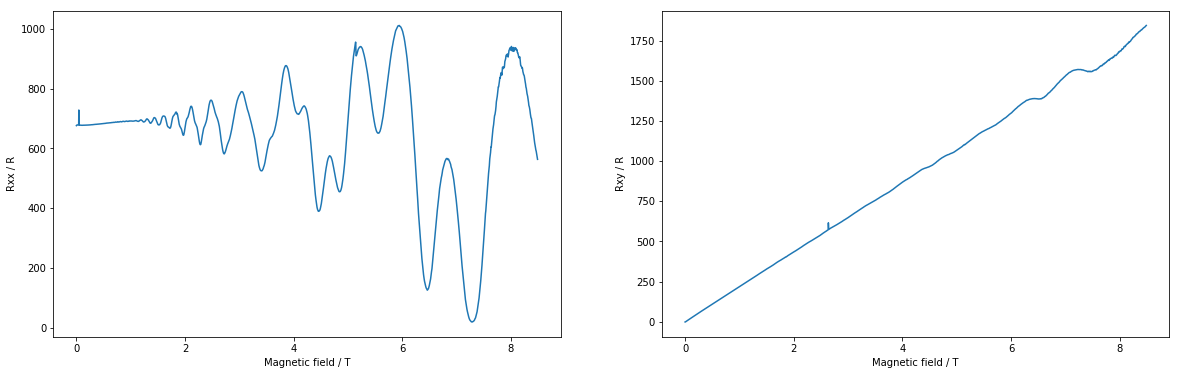

In [24]:
## Load data
loadin("20180723T072923053Z-0015.json")

ac_current = d['0015']['attr']['_devices start']['lockin1']['amplitude'] * d['0015']['attr']['ivvi rack']['Dac 1 output current gain A/V'] * .01
cdf = df['0015'][df['0015']['i'] < 3016]
Rxx = (cdf['AC Voltage xx / V'])/ac_current
Rxy = (cdf['AC Voltage xy / V'])/ac_current
Bmeas = cdf['Measured Field / T']

# Extract rho and density
rho = cdf.iloc[(cdf['Measured Field / T']).abs().argsort()[:1]]['AC Voltage xx / V'].values[0] / (ac_current*4)
tdf = cdf[cdf['Measured Field / T'] < 1]
slope = np.polyfit(tdf['Measured Field / T'],tdf['AC Voltage xy / V']/ac_current,1)
n_total = 1/(slope[0] * e)
mu_total = 1/(rho*n_total*1e-4*e)

## Plot
fig_1b, ax_1b = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
for ax,plot,ylbl in zip(ax_1b,[(Bmeas,Rxx),(Bmeas,Rxy)],['Rxx / R','Rxy / R']):
    ax.plot(*plot)
    ax.set_xlabel('Magnetic field / T')
    ax.set_ylabel(ylbl)
    
# Save figure
plt.savefig('../plots/hallbar1_rxx_rxy.png')

## Overal density and mobility
print('Density and mobility from Rxy:\nn = {0:.2e} '.format(n_total*1e-4)+'cm^-2')
print('mu'+' = {0:.2f} '.format(mu_total)+'cm^2/Vs')

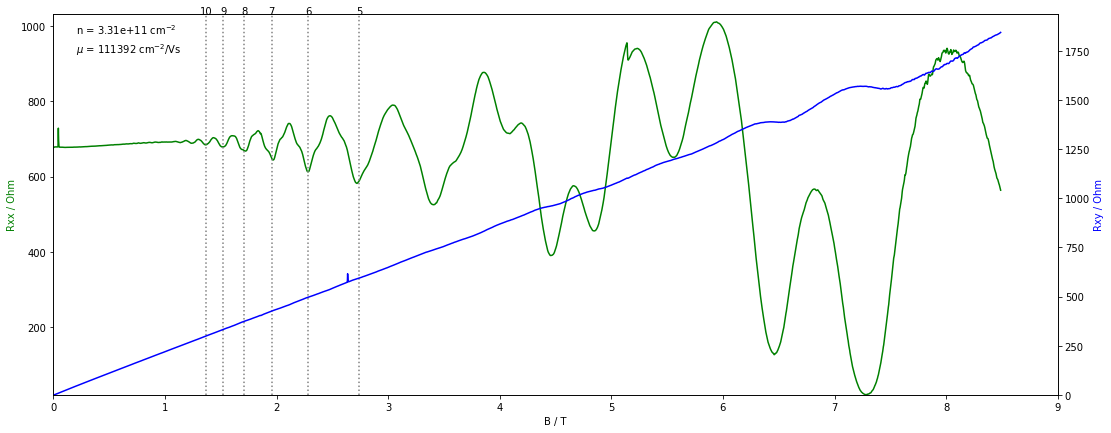

In [33]:
## Filling factors
Bsdh = {0:[1.37,1.52,1.72,1.97,2.28,2.72]} # Shubnikov- de Haas minima from Rxy

[nu_band1, n_band1, mu_band1], [B_nu,nu_all] = single_subband(Bsdh,rho)

## Make overview plot
fig_1c, ax_1c = plt.subplots(figsize=(18,7))
xmax = [min(Rxx)*0.98,0]
ymax = [max(Rxx)*1.02,max(Rxy)*1.05]
for ax,ylims,f,color,label in zip([ax_1c,ax_1c.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [Rxx,Rxy],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,9)
    ax.set_ylim(*ylims)
    ax.plot(Bmeas,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_1c.annotate('n = {0:.2e} '.format(n_band1[0])+u'cm$^{-2}$',(0.2,ymax[0]*.95))
ax_1c.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu_band1[0])+u'cm$^{-2}$/Vs',(0.2,ymax[0]*.9))

# Filling factors
for xc,nuc in zip(B_nu,nu_all):
    ax_1c.axvline(x=xc,color='gray',ls=':')
    ax_1c.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_1c.savefig('../plots/hallbar1_subband1.png')

## FFT of SdH

Estimate subband densities from FFT of SdH

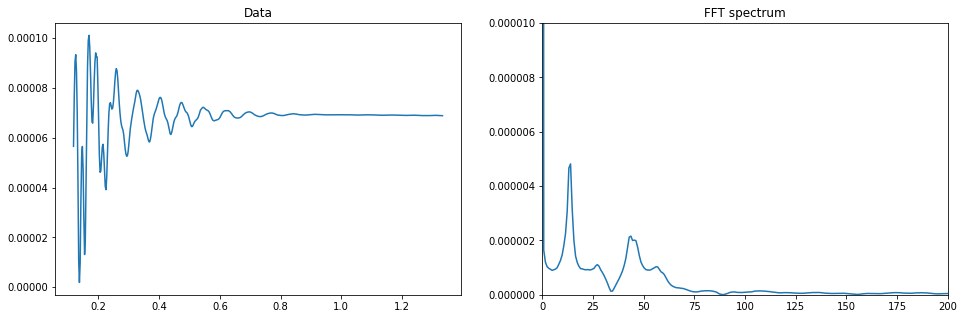

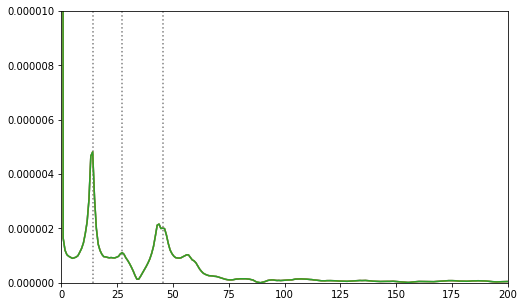

Subband 1 density: 3.40e+11
Subband 2 density: 6.59e+11
Subband 3 density: 1.10e+12
Total density is 2.10e+12 cm^-2


In [41]:
cdf = df['0015'][(df['0015']['i'] < 3016)] # Select the positive up-sweep data
fft_SdH(cdf,'Measured Field / T','AC Voltage xx / V',.75,8.487,N=501,fit=True)

In [42]:
1/(rho*3.4e11*e)

108542.7841828319

## Check field symmetry of data

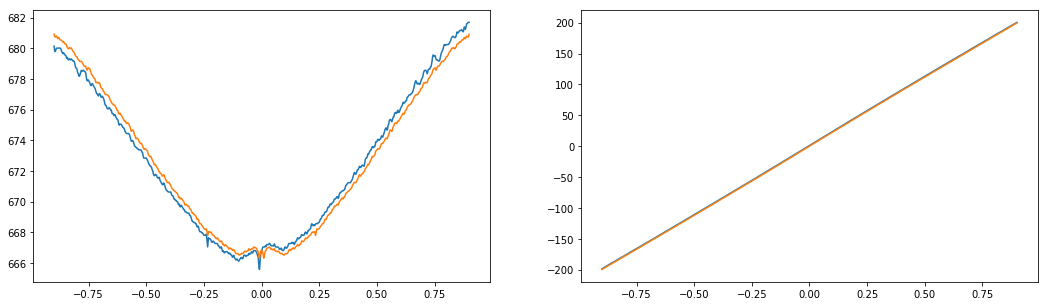

In [35]:
cdf = df['0015'][(df['0015']['i'] > 5674) & (df['0015']['i'] < 6384)]
Rxx = (cdf['AC Voltage xx / V'])/ac_current
Rxy = (cdf['AC Voltage xy / V'])/ac_current
Bmeas = cdf['Measured Field / T']
fxx = sp.interpolate.interp1d(Bmeas,Rxx)
fxy = sp.interpolate.interp1d(Bmeas,Rxy)
B = np.linspace(-0.9,0.9,1001)
# Split even and odd parts (to correct of geometry effects)
Rxx_even = (fxx(B)+fxx(-B))/2
Rxy_odd = (fxy(B)-fxy(-B))/2

#Plot
fig, ax = plt.subplots(ncols=2,figsize=(18,5))
ax[0].plot(B,fxx(B))
ax[0].plot(B,Rxx_even)
ax[1].plot(B,fxy(B))
ax[1].plot(B,Rxy_odd)